<div style="background-color: #ffffff; color: #333; padding: 15px; border: 1px solid #ddd; border-radius: 8px;">
    <a class="anchor" id="1st-bullet"></a>
    <h2 style="color: #795548; font-weight: bold; text-align: center;">Group Project - Data Preprocessing</h2>
    <h3 style="color: #a1887f; text-align: center;">Data Mining 2024/2025</h3>
</div>

<div style="text-align: center;">
    <strong>Group 14</strong>
    <table style="margin: 0 auto; border-collapse: collapse; border: 1px solid black;">
        <tr>
            <th style="border: 1px solid white; padding: 8px;">Name</th>
            <th style="border: 1px solid white; padding: 8px;">Student ID</th>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Francisco Santos</td>
            <td style="border: 1px solid white; padding: 8px;">20240562</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Margarida Raposo</td>
            <td style="border: 1px solid white; padding: 8px;">20241020</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Nuno Nunes</td>
            <td style="border: 1px solid white; padding: 8px;">20240560</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Teresa Menezes</td>
            <td style="border: 1px solid white; padding: 8px;">20240333</td>
        </tr>
    </table>
</div>

### **Structure**
1. [Change](#add)
2. [Change](#add)
3. Feature Engineering ? https://www.kaggle.com/code/karnikakapoor/customer-segmentation-clustering

In [1]:
import pandas as pd
import numpy as np

# import matplotlib.pyplot and seaborn for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

import os
from math import ceil

from scipy import stats

import warnings

In [2]:
df = pd.read_csv('df1.csv')

## Data Preparation

In [3]:
df.drop_duplicates(inplace=True)

In [4]:
# exclude customers with no orders
no_orders = df.loc[:, 'DOW_0':'DOW_6'].sum(axis=1) == 0
no_orders = df[no_orders]

faz sentido ter age e age group ?

In [5]:
# new dataframe with only customers who have ordered
df_customers = df[~df.index.isin(no_orders.index)]

In [6]:
# set customer_id as index
df_customers.set_index('customer_id', inplace=True)

### Missing Values

In [7]:
# get the total number of NaN values for each column
total_nan = df_customers.isna().sum().sort_values(ascending=False)

# get the percentage of NaN values for each column
percent_nan = ((total_nan / len(df_customers)) * 100).round(2)

# create a DataFrame to display the total and percentage of NaN values for each column
nan_stats = pd.DataFrame({'Total NaN': total_nan, 'Percentage NaN': percent_nan})

# no need to display columns with no NaN values
nan_stats = nan_stats[nan_stats['Total NaN'] > 0]

nan_stats

,Total NaN,Percentage NaN
HR_0,1164,3.67
customer_age,727,2.29
age_group,727,2.29
first_order,106,0.33


- Low %, so lets use imputation

- Same % for 'customer_age' and 'age_group' -> NaN values in age_group are probably due to missing values in customer_age

In [8]:
# ignore warnings
warnings.filterwarnings('ignore')

# fill HR_0 with the mean value 
hr_0_mean = df_customers['HR_0'].mean()
df_customers['HR_0'].fillna(hr_0_mean, inplace=True)
hr_0_mean

0.0

In [9]:
# Check if missing age_group aligns with missing customer_age
missing_consistency = df_customers[df_customers['customer_age'].isnull()]['age_group'].isnull().all()
print(f"Are all missing age_group values tied to missing customer_age? {missing_consistency}")

Are all missing age_group values tied to missing customer_age? True


Text(0.5, 1.0, 'Distribution of Customer Age')

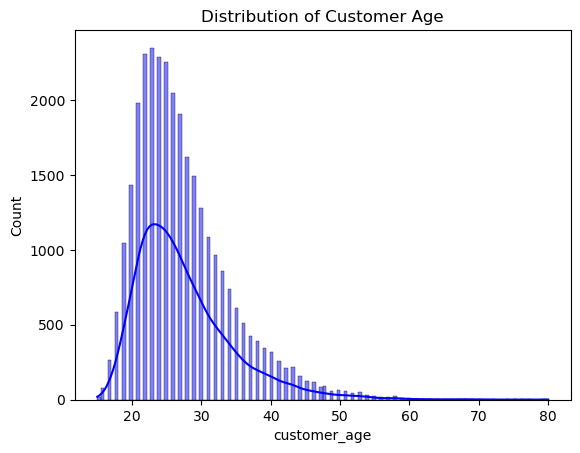

In [10]:
# get distribution of the 'customer_age' column
sns.histplot(df_customers['customer_age'], kde=True, color='blue')
plt.title('Distribution of Customer Age')


- Distribution is right-skewed, let's use the median over the mean

In [11]:
# ignore warnings
warnings.filterwarnings('ignore')

# fill customer_age with the median value
customer_age_median = df_customers['customer_age'].median()  # 26
df_customers['customer_age'].fillna(customer_age_median, inplace=True)

# fill age_group with the respective age group (21-30)
df_customers['age_group'].fillna('21-30', inplace=True)

In [18]:
df_customers

,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,...,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,customer_city,total_amount_spent,age_group,total_orders
customer_id,,,,,,,,,,,,,,,,,,,,,
1b8f824d5e,2360,18.0,2,5,1,0.0,1,DELIVERY,DIGI,0.00,...,2,0,0,0,0,0,2,28.88,0-20,2
5d272b9dcb,8670,17.0,2,2,2,0.0,1,DISCOUNT,DIGI,12.82,...,0,0,0,0,0,0,8,19.21,0-20,2
f6d1b2ba63,4660,38.0,1,2,2,0.0,1,DISCOUNT,CASH,9.20,...,0,0,0,0,0,0,4,9.20,31-40,2
180c632ed8,4660,26.0,2,3,1,0.0,2,DELIVERY,DIGI,0.00,...,0,0,0,0,0,0,4,31.56,21-30,2
4eb37a6705,4660,20.0,2,5,0,0.0,2,-,DIGI,14.57,...,0,0,0,0,0,0,4,55.44,0-20,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eb13c834e7,2360,74.0,1,1,1,89.0,89,DELIVERY,CARD,0.00,...,0,1,0,0,0,0,2,1.75,71-80,1
f7be3a1a84,2440,26.0,1,1,1,89.0,89,-,CASH,0.00,...,0,0,0,0,0,0,2,1.86,21-30,1
fc924e1758,4660,20.0,1,2,0,89.0,89,DELIVERY,CASH,0.00,...,0,0,0,0,0,0,4,23.15,0-20,1


First_Order - Impute with the mean, median or mode doesn't make sense here. As those missing values represent 0.33% let's drop them

In [12]:
# ignore warnings
warnings.filterwarnings('ignore')

# drop rows where first_order is missing
df_customers.dropna(subset=['first_order'], inplace=True)

## Outliers

Standardizing the data is key for most of the clustering techniques to avoid a feature biasing the results of clustering

In [13]:
# metric features
metric_features = df_customers.select_dtypes(include=[np.number]).columns

In [14]:
from sklearn.neighbors import NearestNeighbors

# Using DBScan for Outlier detection:

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_customers[metric_features])
distances, indices = nbrs.kneighbors(df_customers[metric_features])

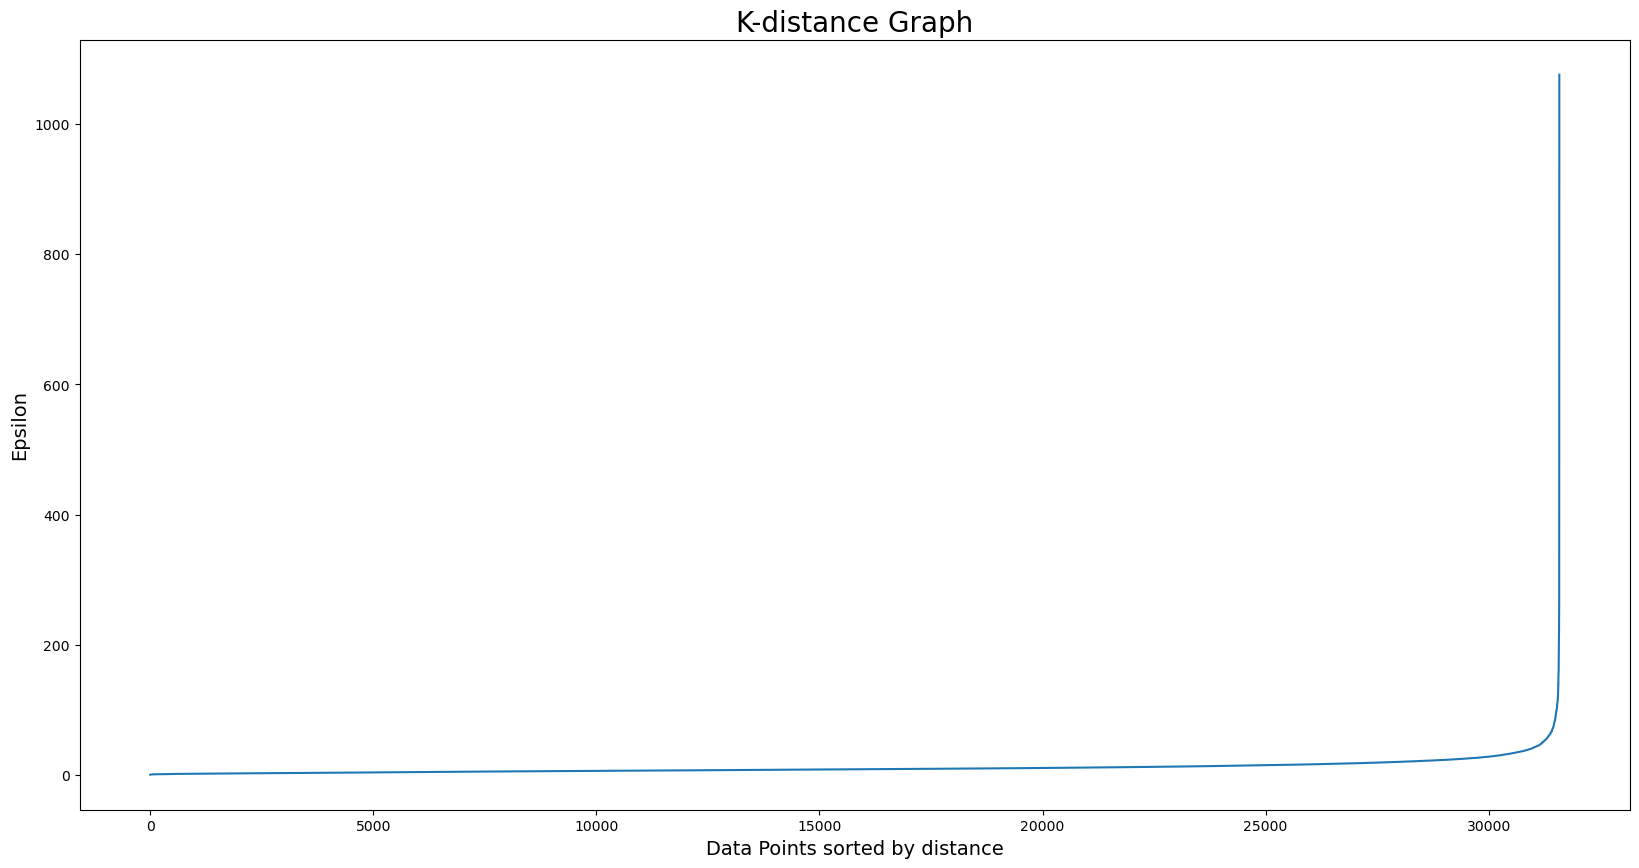

In [15]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [16]:
from kneed import KneeLocator

# distances would be your sorted distance values
kneedle = KneeLocator(range(len(distances)), distances, S=1.0, curve='convex', direction='increasing')

# The elbow point:
elbow_point = kneedle.elbow
print("The elbow point is:", elbow_point)

epsilon = distances[kneedle.elbow]
print("The epsilon value at the elbow point is:", epsilon)

The elbow point is: 31559
The epsilon value at the elbow point is: 136.29916654183904


In [17]:

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

features = metric_features  
data_scaled = df_customers[metric_features]

# Define specific `min_samples` values to test
min_samples_values = [len(metric_features) + 1, 2*len(metric_features),3*len(metric_features)]

# Initialize lists to store the metrics
silhouette_scores = []

# Loop over the specified `min_samples` values
for min_samples in min_samples_values:
    # Run DBSCAN
    db = DBSCAN(eps=136.29916654183904, min_samples=min_samples)
    labels = db.fit_predict(data_scaled)
    
    # Calculate metrics for clusters that have more than one element and not just noise
    if len(set(labels)) > 1 and -1 in labels:
        silhouette_avg = silhouette_score(data_scaled, labels)
        
        # Append metrics to the lists
        silhouette_scores.append(silhouette_avg)

    else:
        # If there's only one cluster or all points are noise, metrics are not meaningful
        silhouette_scores.append(None)

# Print the results
for ms, ss in zip(min_samples_values, silhouette_scores):
    print(f"min_samples: {ms}, Silhouette Score: {ss}")


KeyboardInterrupt: 

In [ ]:
epsilon = 136.29916654183904

min_points = len(metric_features) + 1 # by convention the min_points has to be at least the nr of features plus 1. Indeed 55 + 1 was the one providing the highest silhouette score according to the above output

In [ ]:
model = DBSCAN(eps = epsilon, min_samples = min_points).fit(df_customers[metric_features])

In [ ]:
# outliers dataframe
outliers = df_customers[model.labels_ == -1]
outliers

,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,...,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,customer_city,total_amount_spent,age_group,total_orders
customer_id,,,,,,,,,,,,,,,,,,,,,
249ba584d3,4660,34.0,4,95,8,0.0,71,-,CARD,0.00,...,0,0,0,0,0,0,4,907.86,31-40,54
61327c3c6c,4660,39.0,16,64,27,0.0,75,-,CARD,13.01,...,3,7,1,0,0,0,4,463.63,31-40,42
f11fd892ac,8670,26.0,25,47,12,0.0,80,DELIVERY,CARD,12.77,...,0,0,0,0,0,0,8,467.37,21-30,33
0077c28499,8670,29.0,30,64,17,0.0,81,-,CARD,30.24,...,0,0,0,0,0,2,8,621.04,21-30,46
53ff104b0a,8670,61.0,15,41,18,0.0,83,-,DIGI,0.00,...,0,0,0,0,0,0,8,484.10,61-70,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18a0b88c9d,8670,26.0,12,33,2,18.0,84,-,CASH,0.00,...,0,0,0,0,0,0,8,424.56,21-30,16
6055ec3830,8670,23.0,15,38,3,19.0,86,FREEBIE,CARD,60.29,...,0,0,0,0,0,0,8,508.11,21-30,16
db06018196,8670,21.0,6,27,4,26.0,89,-,CARD,6.63,...,0,0,0,0,0,0,8,286.03,21-30,17


In [ ]:
# Calculate the number of data points in the original dataset
original_data_count = len(df_customers)

# Calculate the number of data points identified as outliers
outliers_count = len(df_customers[model.labels_ == -1])

# Calculate the percentage of data that are outliers
outliers_percentage = (outliers_count / original_data_count) * 100

print(f"Percentage of data identified as outliers: {outliers_percentage:.2f}%")

Percentage of data identified as outliers: 0.22%


In [ ]:
data_no_outliers = df_customers[model.labels_ != -1]